# Предсказание мощности Top 1 суперкомпьютера на 2025

In [59]:
import pathlib

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.forecasting.theta import ThetaModel

%matplotlib inline

mpl.rcParams["figure.figsize"] = (10, 10)
mpl.rcParams["figure.dpi"] = 100
plt.style.use('seaborn')

In [60]:
%load_ext autoreload
%autoreload 2

from notebook_utils import log_transform, inverse_log_transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Данные 

Исходные данные были взяты из таблицы в HTML разметки страницы [top500](https://www.top500.org/statistics/perfdevel/). Таблица есть только в разметке и не отображается в браузере.

In [61]:
data_path = pathlib.Path("data", "all_data", "data.csv")
time_column = "List"

In [62]:
data = pd.read_csv(data_path, engine="c", parse_dates=[time_column], index_col=time_column)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1993-06-01 to 2021-06-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sum_GFlop/s   57 non-null     float64
 1   #1_GFlop/s    57 non-null     float64
 2   #500_GFlop/s  57 non-null     float64
dtypes: float64(3)
memory usage: 1.8 KB


In [64]:
data.tail()

,Sum_GFlop/s,#1_GFlop/s,#500_GFlop/s
List,,,
2019-06-01,1.559575e+09,148600000.0,1021000.0
2019-11-01,1.646887e+09,148600000.0,1142000.0
2020-06-01,2.206134e+09,415530000.0,1228000.0
2020-11-01,2.428762e+09,442010000.0,1316840.0
2021-06-01,2.786059e+09,442010000.0,1511000.0


In [65]:
target_column = "#1_GFlop/s"
target_log_column = "log_#1_GFlop/s"

Применим преобразование $\log_{10}(\cdot)$ к целевой переменной.

In [66]:
data[target_log_column] = log_transform(data[target_column])

## Предварительный анализ

Определяем временной интервал между прогнозами.

In [67]:
data.index.day.unique()

Int64Index([1], dtype='int64', name='List')

По данным видно, что значения прогноза даны только в определённые месяцы, но два раза в год. Интервал между ними 5 месяцев. За исключением 2021 года.

In [68]:
data.groupby(by=data.index.month).count()

,Sum_GFlop/s,#1_GFlop/s,#500_GFlop/s,log_#1_GFlop/s
List,,,,
6,29,29,29,29
11,28,28,28,28


Возьмём последний год в качестве тестового значения для проверки предсказаний.

In [69]:
last_year = 2021

In [70]:
data[data.index.year == last_year]

,Sum_GFlop/s,#1_GFlop/s,#500_GFlop/s,log_#1_GFlop/s
List,,,,
2021-06-01,2.786059e+09,442010000.0,1511000.0,8.645432


In [71]:
data.tail()

,Sum_GFlop/s,#1_GFlop/s,#500_GFlop/s,log_#1_GFlop/s
List,,,,
2019-06-01,1.559575e+09,148600000.0,1021000.0,8.172019
2019-11-01,1.646887e+09,148600000.0,1142000.0,8.172019
2020-06-01,2.206134e+09,415530000.0,1228000.0,8.618602
2020-11-01,2.428762e+09,442010000.0,1316840.0,8.645432
2021-06-01,2.786059e+09,442010000.0,1511000.0,8.645432


Возьмём значения только в 6 месяце и будем использовать их для прогноза, чтобы сделать временной ряд с равными интервалами между измерениями. 

In [72]:
selected_month = 6

In [73]:
data = data[data.index.month == selected_month]
data.index.freq = pd.infer_freq(data.index)

По графику видно, что временной ряд нестационарный.

<AxesSubplot:xlabel='List', ylabel='log_#1_GFlop/s'>

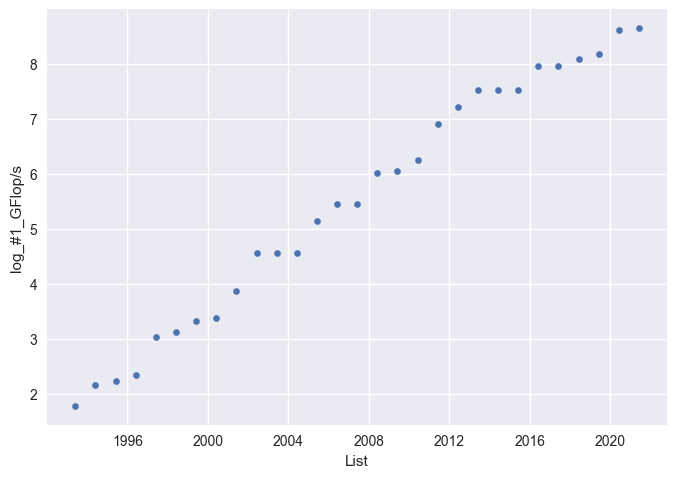

In [74]:
data.reset_index().plot.scatter(x=time_column, y=target_log_column)

## Декомпозиция на составные части 

Из рисунка можно сделать вывод, что временной ряд похож на аддитивную модель. Попробуем разбить на составные части.

In [75]:
add_model = seasonal_decompose(data[target_log_column], model="additive")

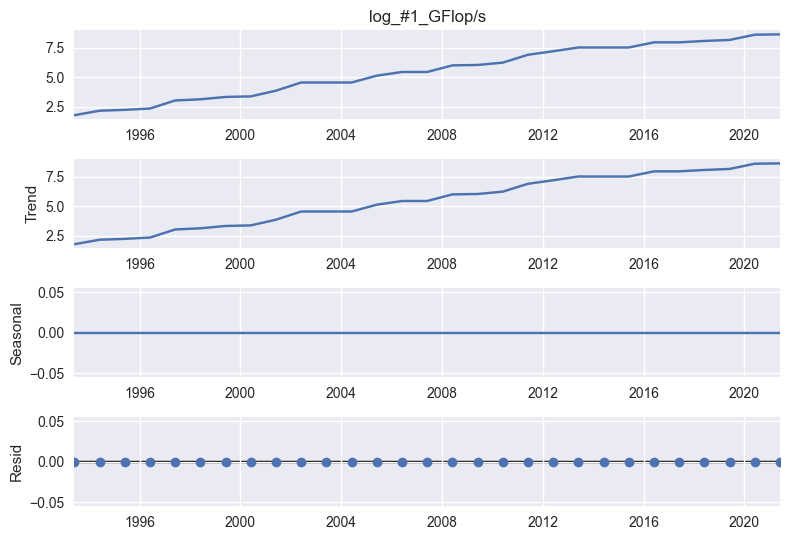

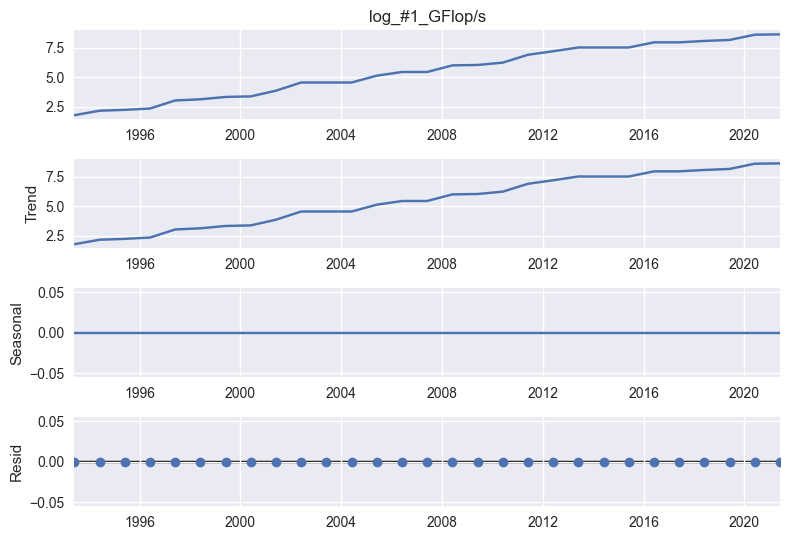

In [76]:
add_model.plot()

Построение автокорреляционной функции. Из графика ниже видно, что существует некоторая зависимость на примерно 10 временных интервалах.

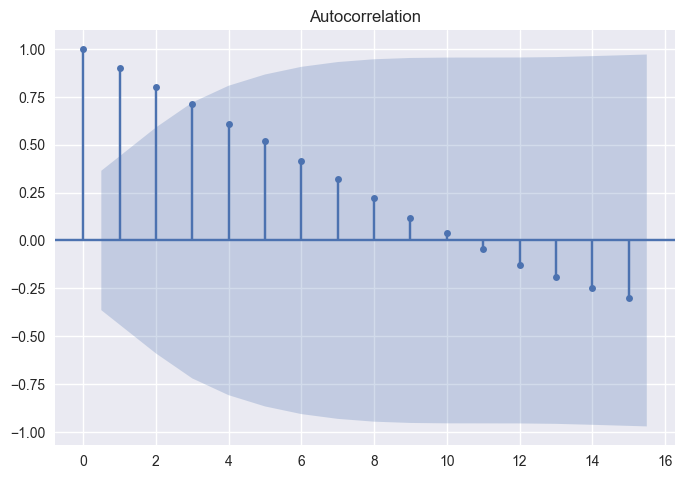

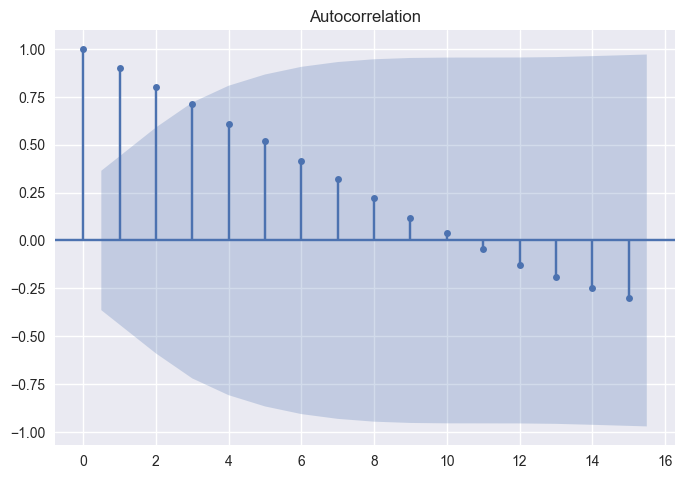

In [77]:
plot_acf(data[target_log_column])

# Построение прогноза с помощью простой Theta модели

In [78]:
forecast_lag = 4
train_size = len(data) - forecast_lag
split_date = data.index[train_size]
train = data[data.index < split_date]
test = data[data.index >= split_date]

significance_level = 0.05

In [79]:
params = {"use_test": True, "deseasonalize": True, "method": "additive"}
use_mle = False

In [80]:
theta_model = ThetaModel(train[target_log_column], **params)
forecasting_model = theta_model.fit(use_mle=use_mle)

In [81]:
print(forecasting_model.summary())
print("Оценка дисперсии невязки: ", forecasting_model.sigma2)

                              ThetaModel Results                              
Dep. Variable:         log_#1_GFlop/s   No. Observations:                   25
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sun, 26 Sep 2021   Deseas. Method:               Additive
Time:                        14:57:49   Period:                              1
Sample:                    06-01-1993                                         
                         - 06-01-2017                                         
  Parameter Estimates   
          Parameters    
------------------------
b0    0.2724399908180285
alpha 0.9998783419742828
------------------------
Оценка дисперсии невязки:  0.036444633242820657


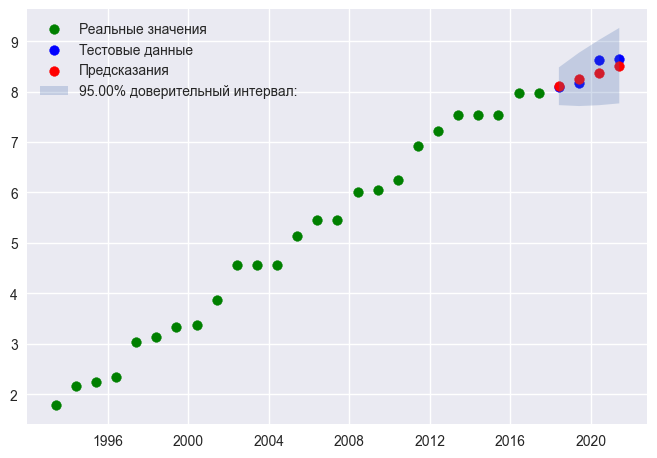

In [82]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(x=train.index, y=train[target_log_column], c="green", label="Реальные значения")
ax.scatter(x=test.index, y=test[target_log_column], c="blue", label="Тестовые данные")
forecast = forecasting_model.forecast(steps=len(test))
pred_interval = forecasting_model.prediction_intervals(steps=len(test))
ax.scatter(x=forecast.index, y=forecast, c="red", label="Предсказания")
ax.fill_between(x=pred_interval.index, y1=pred_interval["lower"], y2=pred_interval["upper"], alpha=0.25, label=f"{1 - significance_level:.2%} доверительный интервал:")
ax.legend()

## Визуализация предсказаний на 2025 год

In [83]:
theta_model = ThetaModel(data[target_log_column], **params)
forecasting_model = theta_model.fit(use_mle=use_mle)
print(forecasting_model.summary())

                              ThetaModel Results                              
Dep. Variable:         log_#1_GFlop/s   No. Observations:                   29
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sun, 26 Sep 2021   Deseas. Method:               Additive
Time:                        14:57:50   Period:                              1
Sample:                    06-01-1993                                         
                         - 06-01-2021                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    0.25740696578896893
alpha  0.9998776820425181
-------------------------


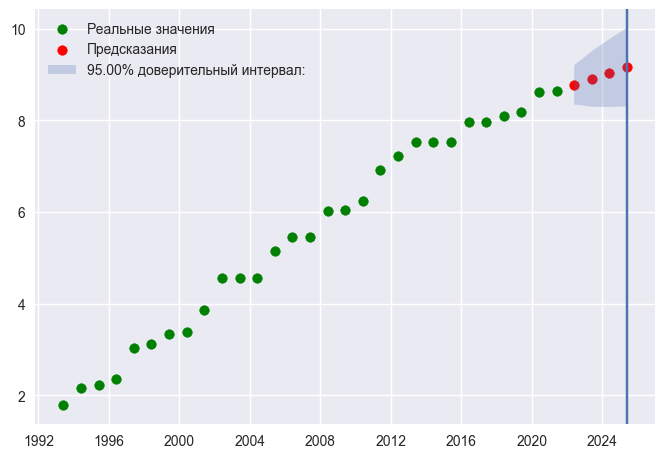

In [84]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(x=data.index, y=data[target_log_column], c="green", label="Реальные значения")
forecast = forecasting_model.forecast(steps=forecast_lag)
pred_interval = forecasting_model.prediction_intervals(steps=forecast_lag)
ax.scatter(x=forecast.index, y=forecast, c="red", label="Предсказания")
ax.fill_between(x=pred_interval.index, y1=pred_interval["lower"], y2=pred_interval["upper"], alpha=0.25, label=f"{1 - significance_level:.2%} доверительный интервал:")
ax.legend()
ax.axvline(forecast.tail(n=1).index, label=f"Предсказание на {forecast.tail(n=1).index}")

In [85]:
final_data = inverse_log_transform(pd.concat((forecast, pred_interval), axis="columns"))

In [86]:
final_data.style.format(thousands=" ", formatter={col: lambda x: "{:.2f} PFlop/s".format(x * 1e-6) for col in ("forecast", "lower", "upper")})\
    .set_caption("Предсказание мощности Top 1 суперкомпьютера с оценками нижней и верхней границы")

,forecast,lower,upper
2022-06-01 00:00:00,594.49 PFlop/s,221.69 PFlop/s,1594.22 PFlop/s
2023-06-01 00:00:00,799.56 PFlop/s,198.15 PFlop/s,3226.27 PFlop/s
2024-06-01 00:00:00,1075.36 PFlop/s,194.78 PFlop/s,5936.98 PFlop/s
2025-06-01 00:00:00,1446.30 PFlop/s,201.12 PFlop/s,10400.60 PFlop/s


Предсказанная мощность Top 1 суперкомпьютер на 2025.

In [87]:
final_data[final_data.index.year == 2025].style.format(thousands=" ", formatter={col: lambda x: "{:.2f} PFlop/s".format(x * 1e-6) for col in ("forecast", "lower", "upper")})\
    .set_caption("Предсказание мощности Top 1 суперкомпьютера с оценками нижней и верхней границы")

,forecast,lower,upper
2025-06-01 00:00:00,1446.30 PFlop/s,201.12 PFlop/s,10400.60 PFlop/s
